# UR SLS Sentinel 10m TC

Kode modelling klasifikasi densenet dan resnet urban rural pada data sentinel 2 10m dengan neighbor True crop, input tingkat SLS.

### Import Fast AI

In [2]:
import fastai
from fastai.vision.all import *
import pandas as pd

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score,balanced_accuracy_score
import numpy as np

Buka data urban rural

In [ ]:
sls = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/3200_sls.csv")

In [4]:
sls.head()

,id,kdprov,kdkab,kdkec,kddesa,iddesa,idslsnon,nmslsnon,ketua_sls,jenis,...,j_bstt,j_bsbtt,j_bstt_k,j_bskeko,j_segmen,dom,ldom,j_m_all,j_m_30,klas_ur
0,263884,32,1,10,1,3201010001,100,RT 001 RW 001 DUSUN 1,MUHAMAD RAFLI HIDAYAT,1,...,39,1,2,4,1,1,1,51,51,2
1,263885,32,1,10,1,3201010001,200,RT 002 RW 001 DUSUN 1,NURMAN,1,...,60,2,0,7,1,1,1,62,61,2
2,263886,32,1,10,1,3201010001,300,RT 003 RW 001 DUSUN 1,SAENUDIN,1,...,50,2,0,6,1,1,1,58,57,2
3,263887,32,1,10,1,3201010001,400,RT 004 RW 001 DUSUN 1,AEP,1,...,27,1,0,1,1,1,1,31,31,2
4,263888,32,1,10,1,3201010001,500,RT 005 RW 001 DUSUN 1,JEJEN JAELANI,1,...,49,7,3,8,3,1,1,63,57,2


In [5]:
sls.iddesa.unique().shape

(5957,)

Alokasi data tingkat SLS ke folder yang bersesuaian

In [ ]:
os.chdir('C:/Users/jwst2/Python/tesis/jpg/jabarslstcur')
if os.path.isdir('urban') is False:
    os.makedirs('urban')
    os.makedirs('rural')

In [ ]:
yourpath = "C:/Users/jwst2/Python/tesis/jpg/jabarslstruecrop/"
from tqdm import tqdm
for root, dirs, files in tqdm(os.walk(yourpath, topdown=False)):
    for name in files:
        try :
            if(sls.klas_ur[sls.iddesa == int(name.replace(".jpg","")[:10])].iloc[0] == 1):
                shutil.copy(os.path.join(root, name), "C:/Users/jwst2/Python/tesis/jpg/jabarslstcur/urban/"+name)
            elif(sls.klas_ur[sls.iddesa == int(name.replace(".jpg","")[:10])].iloc[0] == 2):
                shutil.copy(os.path.join(root, name), "C:/Users/jwst2/Python/tesis/jpg/jabarslstcur/rural/"+name)
        except Exception:
            print(name)
            pass 

Buka data split yang dibentuk pada preprocessing

In [ ]:
split = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/datasplit_ur_desa.csv")

In [73]:
split_test =split

In [74]:
split_test

,Unnamed: 0,iddesa
0,0,3207250012
1,1,3273111002
2,2,3205260016
3,3,3212030010
4,4,3208181004
...,...,...
590,590,3210070009
591,591,3209040007
592,592,3203051007
593,593,3208030017


#### Pembentukan test file di tingkat SLS

In [76]:
yourpath = "C:/Users/jwst2/Python/tesis/jpg/jabarslstcur/rural"
from tqdm import tqdm
for root, dirs, files in tqdm(os.walk(yourpath, topdown=False)):
    for name in files:
        try :
            if(split_test.iddesa.astype(str).str.contains(name[:10]).sum() > 0):
                shutil.move(os.path.join(root, name), "C:/Users/jwst2/Python/tesis/jpg/sls tc 10m test/rural/"+name)
        except Exception:
            print(name)
            pass 

1it [00:31, 31.91s/it]


In [77]:
yourpath = "C:/Users/jwst2/Python/tesis/jpg/jabarslstcur/urban"
from tqdm import tqdm
for root, dirs, files in tqdm(os.walk(yourpath, topdown=False)):
    for name in files:
        try :
            if(split_test.iddesa.astype(str).str.contains(name[:10]).sum() > 0):
                shutil.move(os.path.join(root, name), "C:/Users/jwst2/Python/tesis/jpg/sls tc 10m test/urban/"+name)
        except Exception:
            print(name)
            pass 

1it [01:56, 116.83s/it]


### Preprocessing Image Input SLS

In [4]:
path = Path.cwd() / ("C:/Users/jwst2/Python/tesis/jpg/UR/04. Sentinel 10M SLS TC")

In [5]:
Path.BASE_PATH = path
path.ls()

(#2) [Path('rural'),Path('urban')]

In [6]:
fname = (path/"rural").ls()[0]
fname

Path('rural/32010100010001.jpg')

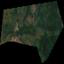

In [7]:
img = Image.open(fname)
img

In [8]:
blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=RandomSplitter(valid_pct=0.1, seed=42),  # default random split 80% training, 20% validation
                 get_y=parent_label # extracts the label category from the image's folder name 
                 ) # data augmentation (mult multiplies the default transformation values)

In [9]:
dls = blocks.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


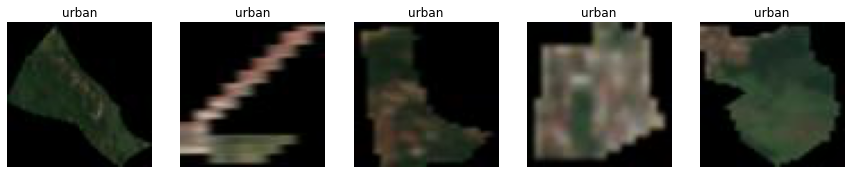

In [10]:
dls.show_batch(nrows=1, ncols=5)

### Densenet 

Pemodelan di tingat sls dengan densenet

In [11]:
avg = 'macro'
roca = RocAucBinary(average=avg)
f1s = F1Score(average=avg)
bc = BalancedAccuracy()
metrics=[accuracy,bc, Precision(average=avg), Recall(average=avg), f1s, roca]
learn = cnn_learner(dls, densenet121, metrics=metrics) 

C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\fastai\vision\learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


SuggestedLRs(valley=0.002511886414140463)

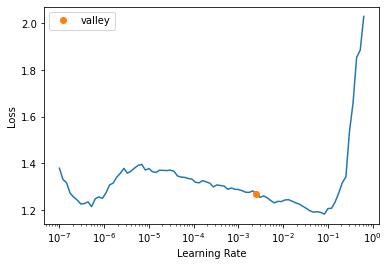

In [12]:
learn.lr_find()

In [16]:
learn.fit_one_cycle(3,1e-2)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.391004,0.388740,0.808410,0.565722,0.782528,0.565722,0.566150,0.841533,12:30
1,0.385151,0.372036,0.825593,0.643357,0.764237,0.643357,0.669775,0.850879,09:29
2,0.369403,0.370161,0.825239,0.666100,0.748928,0.666100,0.690448,0.851902,09:22


In [17]:
learn.unfreeze()

In [85]:
learn.fit_one_cycle(3,1e-2)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.376793,0.381908,0.816698,0.603259,0.766075,0.603259,0.621596,0.847712,11:44
1,0.387785,0.372478,0.822712,0.639528,0.755928,0.639528,0.664805,0.851738,12:28
2,0.374527,0.363881,0.824885,0.664919,0.748415,0.664919,0.689270,0.857132,12:36


In [20]:
dls.vocab

['rural', 'urban']

In [21]:
dls.train.items[175000]

Path('urban/32731900050057.jpg')

In [24]:
learn.export('C:/Users/jwst2/Python/tesis/models/18042022 D007.pkl')

### Proses voting ensembel ke tingkat desa

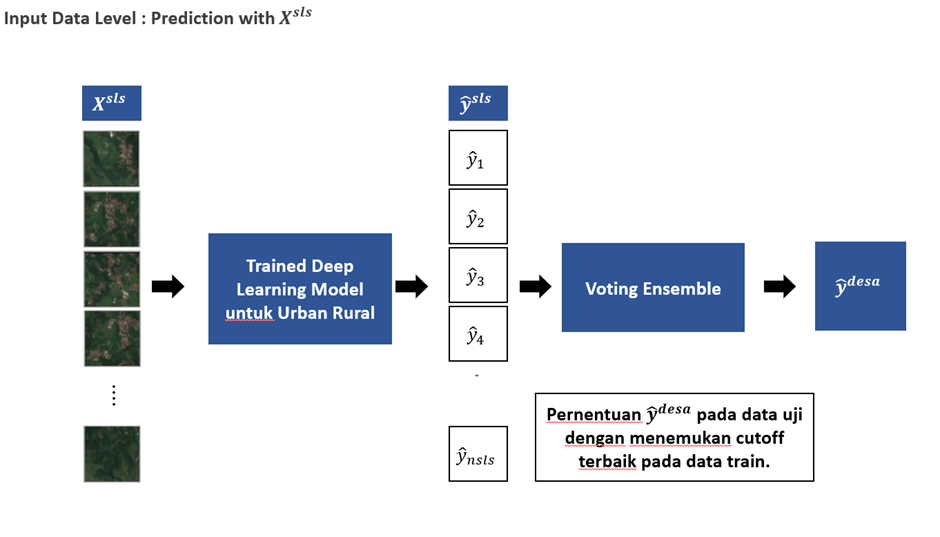

Load train index

In [22]:
idx_train = []
for i in dls.train.items:
    idx_train.append(str(i)[-18:-4])
true_label = []
for i in dls.train.items:
    if("urban" in str(i)) :
        true_label.append(1)
    else :
        true_label.append(0)

Mengambil softmax train index

In [23]:
preds,_ = learn.get_preds(ds_idx  = 0)
result_train = preds.numpy()
new_train = pd.DataFrame(result_train)

In [24]:
pd.value_counts(true_label)

1    140261
0     37828
dtype: int64

Pembentukan data ses prediksi SLS

In [25]:
df = new_train
df["idsls"] = idx_train 
df["stat"] = round(df[1])
df["iddesa"] = df.idsls.str[:10]
df.head()

,0,1,idsls,stat,iddesa
0,0.590321,0.409679,32053100190023,0.0,3205310019
1,0.360219,0.639781,32061110010013,1.0,3206111001
2,0.011482,0.988518,32091300140021,1.0,3209130014
3,0.161676,0.838324,32091610060002,1.0,3209161006
4,0.221717,0.778283,32062610040007,1.0,3206261004


In [26]:
pd.value_counts(df.stat)

1.0    153520
0.0     24569
Name: stat, dtype: int64

In [27]:
df["true_lab"] = true_label

In [28]:
pd.value_counts(df.true_lab)

1    140261
0     37828
Name: true_lab, dtype: int64

In [29]:
accuracy_score(df.stat.apply(int),df.true_lab.apply(int))

0.8278445047139351

In [30]:
df.head()

,0,1,idsls,stat,iddesa,true_lab
0,0.590321,0.409679,32053100190023,0.0,3205310019,0
1,0.360219,0.639781,32061110010013,1.0,3206111001,0
2,0.011482,0.988518,32091300140021,1.0,3209130014,1
3,0.161676,0.838324,32091610060002,1.0,3209161006,1
4,0.221717,0.778283,32062610040007,1.0,3206261004,0


In [31]:
desa_pred = df.groupby('iddesa').agg({'stat': ['mean'], 'true_lab': 'mean'})

In [32]:
desa_pred.columns = ["pred","true"]

In [33]:
pd.value_counts(df.stat)

1.0    153520
0.0     24569
Name: stat, dtype: int64

#### Proses penentuan cutoff untuk voting ensemble

In [34]:
for i in np.arange(0.1, 0.95, 0.05):
    value = round(i,2)
    desa_pred["label"+str(value)] = 0
    desa_pred["label"+str(value)][desa_pred.pred > value] = 1

C:\Users\jwst2\AppData\Local\Temp/ipykernel_1640/4109382162.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desa_pred["label"+str(value)][desa_pred.pred > value] = 1


In [35]:
desa_pred.head()

,pred,true,label0.1,label0.15,label0.2,label0.25,label0.3,label0.35,label0.4,label0.45,label0.5,label0.55,label0.6,label0.65,label0.7,label0.75,label0.8,label0.85,label0.9
iddesa,,,,,,,,,,,,,,,,,,,
3201010001,0.140351,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3201010002,0.568182,0.0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0
3201010003,0.600000,1.0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0
3201010004,0.765957,0.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0
3201010005,0.724138,1.0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0


In [36]:
for j in range(2,19):
    print("result", desa_pred.columns[j])
    print("accuracy :",  accuracy_score( desa_pred.true,desa_pred.iloc[:,[j]]))
    print("precision :",  precision_score( desa_pred.true,desa_pred.iloc[:,[j]]))

result label0.1
accuracy : 0.7467362924281984
precision : 0.7411606456571868
result label0.15
accuracy : 0.7536367027228646
precision : 0.7475218658892129
result label0.2
accuracy : 0.7603506154419992
precision : 0.7539823008849558
result label0.25
accuracy : 0.7689295039164491
precision : 0.7619047619047619
result label0.3
accuracy : 0.7763894069377099
precision : 0.7692152511599758
result label0.35
accuracy : 0.7816113390525923
precision : 0.775260257195346
result label0.4
accuracy : 0.7885117493472585
precision : 0.7841995841995842
result label0.45
accuracy : 0.794479671764267
precision : 0.7922654268808115
result label0.5
accuracy : 0.8010070869078701
precision : 0.8024184841286979
result label0.55
accuracy : 0.8043640432674375
precision : 0.808357033471888
result label0.6
accuracy : 0.8103319656844461
precision : 0.8171301446051168
result label0.65
accuracy : 0.8155538977993286
precision : 0.8267877412031782
result label0.7
accuracy : 0.8168593808280492
precision : 0.8366775548296

In [37]:
from sklearn.metrics import confusion_matrix

In [38]:
pd.value_counts(desa_pred.true)

1.0    3868
0.0    1494
Name: true, dtype: int64

#### Prediksi Test result dengan resnet

In [39]:
path_pred = Path.cwd() / ("C:/Users/jwst2/Python/tesis/jpg/UR/test sls 10m tc")
test_files = [fn for fn in sorted((path_pred).glob('**/*')) if fn.is_file()]

In [40]:
len(test_files)

22054

In [41]:
test_dl = learn.dls.test_dl(test_files)

In [42]:
preds,_ = learn.get_preds(dl  =test_dl)

In [43]:
str(test_files[1])[-18:-4]

'32011500010002'

In [44]:
idx_test = []
for i in test_files:
    idx_test.append(str(i)[-18:-4])
true_label = []
for i in test_files:
    if("urban" in str(i)) :
        true_label.append(1)
    else :
        true_label.append(0)

In [45]:
test = pd.DataFrame(preds)

In [46]:
test["idsls"] = idx_test
test["true_lab"] = true_label

In [47]:
test["iddesa"] = test.idsls.str[:10]
test["stat"] = round(test[1])

In [48]:
test.head()

,0,1,idsls,true_lab,iddesa,stat
0,0.649700,0.350300,32011500010001,0,3201150001,0.0
1,0.832094,0.167906,32011500010002,0,3201150001,0.0
2,0.675756,0.324244,32011500010003,0,3201150001,0.0
3,0.764606,0.235394,32011500010004,0,3201150001,0.0
4,0.601013,0.398987,32011500010005,0,3201150001,0.0


In [49]:
desa_pred_test = test.groupby('iddesa').agg({'stat': ['mean'], 'true_lab': 'mean'})

In [50]:
desa_pred_test

,stat,true_lab
,mean,mean
iddesa,,
3201010010,0.8,1.0
3201040001,1.0,1.0
3201040005,1.0,1.0
3201050012,1.0,1.0
3201050013,1.0,1.0
...,...,...
3278050003,1.0,1.0
3278071005,1.0,1.0


In [51]:
desa_pred_test.columns = ["pred","true"]

In [82]:
desa_pred_test["pred_lab"] = 0
desa_pred_test["pred_lab"][desa_pred_test.pred > 0.775] = 1

C:\Users\jwst2\AppData\Local\Temp/ipykernel_1640/2742235302.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desa_pred_test["pred_lab"][desa_pred_test.pred > 0.775] = 1


In [83]:
desa_pred_test

,pred,true,pred_lab
iddesa,,,
3201010010,0.8,1.0,1
3201040001,1.0,1.0,1
3201040005,1.0,1.0,1
3201050012,1.0,1.0,1
3201050013,1.0,1.0,1
...,...,...,...
3278050003,1.0,1.0,1
3278071005,1.0,1.0,1
3278080002,1.0,1.0,1


Hasil predikasi test input sls ke tingkat desa

In [84]:
print("accuracy :",  accuracy_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("balanced_accuracy_score :",  balanced_accuracy_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("precision :",  precision_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("recall :",  recall_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("f1 :",  f1_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("rocauc :",  roc_auc_score( desa_pred_test.true,desa_pred_test.pred_lab))

accuracy : 0.8235294117647058
balanced_accuracy_score : 0.7615144418423108
precision : 0.8577777777777778
recall : 0.9039812646370023
f1 : 0.880273660205245
rocauc : 0.7615144418423108


### Resnet

Proses pemodelan resnet sama dengan resnet.

In [13]:
learn_rs = cnn_learner(dls, resnet50, metrics=metrics) 

SuggestedLRs(valley=0.0002754228771664202)

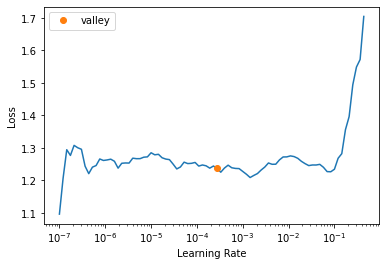

In [14]:
learn_rs.lr_find()

In [71]:
learn_rs.fit_one_cycle(3,1e-3)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.388422,0.384691,0.820842,0.664528,0.737437,0.664528,0.686895,0.838516,07:37
1,0.376127,0.371534,0.825239,0.682282,0.743421,0.682282,0.703302,0.849047,07:34
2,0.368486,0.369326,0.825037,0.661535,0.750416,0.661535,0.686446,0.850990,07:36


In [72]:
learn_rs.unfreeze()

In [74]:
learn_rs.fit_one_cycle(3,1e-3)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.386741,0.381546,0.822560,0.672491,0.739519,0.672491,0.694257,0.844003,09:21
1,0.378548,0.369196,0.825239,0.659836,0.751889,0.659836,0.685060,0.851662,09:25
2,0.387002,0.367868,0.824279,0.660880,0.748435,0.660880,0.685504,0.852702,09:22


In [75]:
learn_rs.export('C:/Users/jwst2/Python/tesis/models/19042022 R007.pkl')

In [76]:
idx_train = []
for i in dls.train.items:
    idx_train.append(str(i)[-18:-4])
true_label = []
for i in dls.train.items:
    if("urban" in str(i)) :
        true_label.append(1)
    else :
        true_label.append(0)

In [77]:
preds,_ = learn_rs.get_preds(ds_idx  = 0)
result_train = preds.numpy()
new_train = pd.DataFrame(result_train)

In [90]:
df = new_train
df["idsls"] = idx_train 
df["stat"] = round(df[1])
df["iddesa"] = df.idsls.str[:10]
df.head()

,0,1,idsls,stat,iddesa,true_lab
0,0.495136,0.504864,32053100190023,1.0,3205310019,0
1,0.350636,0.649364,32061110010013,1.0,3206111001,0
2,0.045631,0.954369,32091300140021,1.0,3209130014,1
3,0.228034,0.771966,32091610060002,1.0,3209161006,1
4,0.190970,0.809030,32062610040007,1.0,3206261004,0


In [91]:
pd.value_counts(df.stat)

1.0    156280
0.0     21809
Name: stat, dtype: int64

In [92]:
df["true_lab"] = true_label

In [93]:
pd.value_counts(df.true_lab)

1    140261
0     37828
Name: true_lab, dtype: int64

In [94]:
accuracy_score(df.stat.apply(int),df.true_lab.apply(int))

0.8257668918349814

In [95]:
df.head()

,0,1,idsls,stat,iddesa,true_lab
0,0.495136,0.504864,32053100190023,1.0,3205310019,0
1,0.350636,0.649364,32061110010013,1.0,3206111001,0
2,0.045631,0.954369,32091300140021,1.0,3209130014,1
3,0.228034,0.771966,32091610060002,1.0,3209161006,1
4,0.190970,0.809030,32062610040007,1.0,3206261004,0


In [96]:
desa_pred = df.groupby('iddesa').agg({'stat': ['mean'], 'true_lab': 'mean'})

In [97]:
desa_pred.columns = ["pred","true"]

In [98]:
pd.value_counts(df.stat)

1.0    156280
0.0     21809
Name: stat, dtype: int64

In [99]:
for i in np.arange(0.1, 0.95, 0.025):
    value = round(i,2)
    desa_pred["label"+str(value)] = 0
    desa_pred["label"+str(value)][desa_pred.pred > value] = 1

C:\Users\jwst2\AppData\Local\Temp/ipykernel_5792/935834860.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desa_pred["label"+str(value)][desa_pred.pred > value] = 1


In [100]:
desa_pred.head()

,pred,true,label0.1,label0.12,label0.15,label0.18,label0.2,label0.22,label0.25,label0.27,...,label0.7,label0.72,label0.75,label0.77,label0.8,label0.82,label0.85,label0.87,label0.9,label0.92
iddesa,,,,,,,,,,,,,,,,,,,,,
3201010001,0.157895,0.0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3201010002,0.545455,0.0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3201010003,0.700000,1.0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3201010004,0.829787,0.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,0,0,0
3201010005,0.724138,1.0,1,1,1,1,1,1,1,1,...,1,1,0,0,0,0,0,0,0,0


In [101]:
for j in range(2,36):
    print("result", desa_pred.columns[j])
    print("accuracy :",  accuracy_score( desa_pred.true,desa_pred.iloc[:,[j]]))
    print("precision :",  precision_score( desa_pred.true,desa_pred.iloc[:,[j]]))

result label0.1
accuracy : 0.7413278627377844
precision : 0.7368722551078862
result label0.12
accuracy : 0.7444983215218202
precision : 0.7393637408968954
result label0.15
accuracy : 0.7487877657590452
precision : 0.7429177105415301
result label0.18
accuracy : 0.7525177172696755
precision : 0.7461732222437513
result label0.2
accuracy : 0.7549421857515852
precision : 0.748733930658356
result label0.22
accuracy : 0.7566206639313688
precision : 0.7502440929505956
result label0.25
accuracy : 0.7614696008951883
precision : 0.7547726825428065
result label0.27
accuracy : 0.7638940693770981
precision : 0.756911532385466
result label0.3
accuracy : 0.7691160014919806
precision : 0.7618478693747511
result label0.32
accuracy : 0.7706079820962327
precision : 0.7636945221911235
result label0.35
accuracy : 0.7747109287579261
precision : 0.7676056338028169
result label0.37
accuracy : 0.7754569190600522
precision : 0.7694174757281553
result label0.4
accuracy : 0.7812383439015292
precision : 0.775280898

### Test result resnet

In [102]:
path_pred = Path.cwd() / ("C:/Users/jwst2/Python/tesis/jpg/UR/test sls 10m tc")
test_files = [fn for fn in sorted((path_pred).glob('**/*')) if fn.is_file()]

In [103]:
test_dl = learn_rs.dls.test_dl(test_files)

In [104]:
preds,_ = learn_rs.get_preds(dl  =test_dl)

In [105]:
idx_test = []
for i in test_files:
    idx_test.append(str(i)[-18:-4])
true_label = []
for i in test_files:
    if("urban" in str(i)) :
        true_label.append(1)
    else :
        true_label.append(0)

In [106]:
test = pd.DataFrame(preds)

In [107]:
test["idsls"] = idx_test
test["true_lab"] = true_label

In [108]:
test["iddesa"] = test.idsls.str[:10]
test["stat"] = round(test[1])

In [109]:
test.head()

,0,1,idsls,true_lab,iddesa,stat
0,0.644363,0.355637,32011500010001,0,3201150001,0.0
1,0.845795,0.154205,32011500010002,0,3201150001,0.0
2,0.644810,0.355190,32011500010003,0,3201150001,0.0
3,0.716973,0.283027,32011500010004,0,3201150001,0.0
4,0.676812,0.323188,32011500010005,0,3201150001,0.0


In [110]:
desa_pred_test = test.groupby('iddesa').agg({'stat': ['mean'], 'true_lab': 'mean'})

In [111]:
desa_pred_test.columns = ["pred","true"]

In [114]:
desa_pred_test["pred_lab"] = 0
desa_pred_test["pred_lab"][desa_pred_test.pred > 0.81] = 1

C:\Users\jwst2\AppData\Local\Temp/ipykernel_5792/3903990358.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desa_pred_test["pred_lab"][desa_pred_test.pred > 0.81] = 1


In [115]:
print("accuracy :",  accuracy_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("balanced_accuracy_score :",  balanced_accuracy_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("precision :",  precision_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("recall :",  recall_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("f1 :",  f1_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("rocauc :",  roc_auc_score( desa_pred_test.true,desa_pred_test.pred_lab))

accuracy : 0.8302521008403362
balanced_accuracy_score : 0.7716139734582357
precision : 0.8638392857142857
recall : 0.9063231850117096
f1 : 0.8845714285714286
rocauc : 0.7716139734582357


In [156]:
accuracy : 0.8302521008403362
balanced_accuracy_score : 0.7716139734582357
precision : 0.8638392857142857
recall : 0.9063231850117096
f1 : 0.8845714285714286
rocauc : 0.7716139734582357